In [26]:
import pandas as pd
import mytools
from geographiclib.geodesic import Geodesic
from shapely.geometry import Polygon,Point,LineString
import geopandas as gpd
from shapely.ops import unary_union

# 第五版本覆盖空洞
### 使用天线方向模型进行修正
使用农村1500距离和1800距离为半径
### 使用每十度一个扇形修正
使用270-90度的方向图层为有效数据

In [64]:
#导入工参数据
gongcan = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/20200712第四版本/1-基础数据/ltejizhan20200616&微站_合并.csv',encoding='gbk'),usecols=[
    '小区CGI(*)','所属地区','小区中文名','RRU经度', 'RRU纬度','天线挂高','工作频段', '方位角','归属区县','厂家名称' ])
#设置变量通用名
print('设置变量通用名')
id = '小区CGI(*)'
lon = 'RRU经度'
lat = 'RRU纬度'
zhishi = '工作频段'
fw = '方位角'

gongcan = gongcan.loc[(gongcan['RRU经度']>108)&
            (gongcan['RRU经度']<117)&
            (gongcan['RRU纬度']>28)&
            (gongcan['RRU纬度']<34)&
           (gongcan['方位角'].notnull())]

设置变量通用名


In [65]:
#只要宏站
gongcan['小区中文名'] = gongcan['小区中文名'].fillna('无')
gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('W-')]
gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('R')]
# gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('M-')]

In [66]:
gongcan['小区中文名'] = gongcan['小区中文名'].fillna('无')
gongcan.loc[gongcan['小区中文名'].str.contains('M-')].shape

(18096, 10)

In [67]:
#打标场景
gongcan = mytools.gisn.points_coverage_merge(gongcan,lon,lat)
print('添加覆盖距离')
gongcan_loc_juli = mytools.gisn.changjing_distance(gongcan,'区域类型',zhishi)

添加覆盖距离


In [70]:
gongcan_loc_juli.loc[(gongcan_loc_juli['区域类型']=='农村')&(gongcan_loc_juli['工作频段']=='FDD900'),'distance']=1500

In [71]:
gongcan_loc_juli.head(1)

,小区CGI(*),小区中文名,所属地区,RRU经度,RRU纬度,天线挂高,方位角,工作频段,归属区县,厂家名称,区域类型,distance
0,460-00-52246-2,公安群力-ELH-2,荆州,112.14735,30.12405,42.0,157.0,F,公安县,爱立信,农村,1000.0


# 覆盖模型修正

In [72]:
gongcan_loc_juli['工作频段'] = gongcan_loc_juli['工作频段'].apply(lambda x: 900 if x=='FDD900' else 1800)

gd,band= map(np.log10, (gongcan_loc_juli['天线挂高'],gongcan_loc_juli['工作频段']))

gongcan_loc_juli['覆盖模型距离'] = np.power(10,
                                      (148 - (46.3+33.9*band-13.82*gd-(-3.81))- 3)/(44.9-6.55*gd))*1000

gongcan_loc_juli['30米覆盖模型距离'] = np.power(10,
                                      (148 - (46.3+33.9*band-13.82*np.log10(30)-(-3.81))- 3)/(44.9-6.55*np.log10(30)))*1000

gongcan_loc_juli['使用覆盖半径'] = gongcan_loc_juli['覆盖模型距离'] /gongcan_loc_juli['30米覆盖模型距离']*gongcan_loc_juli['distance']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [73]:
def fuck(x):
    if x['区域类型']=='主城区':
        if x['工作频段']==900:
            if x['使用覆盖半径']<200:
                return 200
            elif x['使用覆盖半径']>400:
                return 400
            else:
                return x['使用覆盖半径']
        else:
            if x['使用覆盖半径']<150:
                return 150
            elif x['使用覆盖半径']>350:
                return 350
            else:
                return x['使用覆盖半径']
    elif  x['区域类型']=='县城':
        if x['工作频段']==900:
            if x['使用覆盖半径']<300:
                return 300
            elif x['使用覆盖半径']>430:
                return 430
            else:
                return x['使用覆盖半径']
        else:
            if x['使用覆盖半径']<250:
                return 250
            elif x['使用覆盖半径']>400:
                return 400
            else:
                return x['使用覆盖半径']
    elif  x['区域类型']=='一般城区':
        if x['工作频段']==900:
            if x['使用覆盖半径']<400:
                return 400
            elif x['使用覆盖半径']>1200:
                return 1200
            else:
                return x['使用覆盖半径']
        else:
            if x['使用覆盖半径']<350:
                return 350
            elif x['使用覆盖半径']>800:
                return 800
            else:
                return x['使用覆盖半径']
    elif  x['区域类型']=='乡镇':
        if x['工作频段']==900:
            if x['使用覆盖半径']<430:
                return 430
            elif x['使用覆盖半径']>2200:
                return 2200
            else:
                return x['使用覆盖半径']
        else:
            if x['使用覆盖半径']<400:
                return 400
            elif x['使用覆盖半径']>1000:
                return 1000
            else:
                return x['使用覆盖半径']
    elif  x['区域类型']=='农村':
        if x['工作频段']==900:
            if x['使用覆盖半径']<1200:
                return 1200
            elif x['使用覆盖半径']>2500:
                return 2500
            else:
                return x['使用覆盖半径']
        else:
            if x['使用覆盖半径']<800:
                return 800
            elif x['使用覆盖半径']>1500:
                return 1500
            else:
                return x['使用覆盖半径']
    else:
        return 0

In [74]:
gongcan_loc_juli['distance_use'] = gongcan_loc_juli.apply(fuck,axis=1)

# 按照周边建筑高度修复

In [54]:
jd_dp = mytools.othern.pickle_read('G:/mypy/mycloud/jupyter/2_评估/覆盖空洞/20200902评估覆盖空洞-第四版本-覆盖空洞使用天线方向图进行/1-基础数据/44低增益900M0下倾P3_935覆盖模型.data')

In [55]:
jd_dp.to_clipboard()

In [29]:
def jm(x):
    jl = int(x['距离'])
    lon = x['lon']
    lat = x['lat']
    fw = x['方位角']
    jd_dp['距离'] = jd_dp['电平_正'].apply(lambda x: x/37.052 *jl)
    jd_dp_use = jd_dp.loc[(jd_dp['角度']<=90) | (jd_dp['角度']>=270)]
    jd_dp_use['角度'] = pd.to_numeric(jd_dp_use['角度'] )
    jd_dp_use['角度2'] = jd_dp_use['角度'].apply(lambda x: x-0+fw if x-0+fw<360 else x-0+fw-360 )
    points=[]
    dict_use = dict()
    for jiao , jl in zip(jd_dp_use['角度2'],jd_dp_use['距离']):
        res = Geodesic.WGS84.Direct(lat, lon, jiao, jl)
        if int(jiao)%10==0:
            dict_use[jiao]=res['lon2'], res['lat2']
        points.append((res['lon2'], res['lat2']))
    points.append(points[0])
    pol = Polygon(points)
    lins=[]
    for key,data_t in dict_use.items():
        lon2,lat2=data_t
        lins.append((lon,lat))
        lins.append((lon2,lat2))
    lins = [LineString([(lon, lat), (data_t[0], data_t[1])]) for key,data_t in dict_use.items()]
    buffer_size = 0.00000000001
    lines_buffered = [line.buffer(buffer_size) for line in lins]
    quadrats = unary_union(lines_buffered)
    multipoly = pol.difference(quadrats)
    return multipoly

In [30]:
# data = data.set_index('cgi')

In [31]:
data['geolin'] = data.apply(jm,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [32]:
gdfdata = gpd.GeoDataFrame(data, crs={'init': 'epsg:4326'},geometry='geolin')

In [33]:
gdfdata['type'] = gdfdata.type

In [34]:
gdfdata.groupby('type').count()

,cgi,小区中文名,网络制式(TDD/FDD),所属地区,工程参数标识,lon,lat,天线挂高,覆盖类型,方位角,机械下倾角,电子下倾角,天线厂家,工作频段,归属区县,厂家名称,所属eNodeB名称,中心载频的信道号,距离,geolin
type,,,,,,,,,,,,,,,,,,,,
MultiPolygon,132,132,132,132,132,132,132,132,132,132,132,132,107,132,132,132,132,132,132,132


In [39]:
data_fg = gdfdata.explode().reset_index(drop=1)

In [49]:
gdfdata.loc[1:1,]

,cgi,小区中文名,网络制式(TDD/FDD),所属地区,工程参数标识,lon,lat,天线挂高,覆盖类型,方位角,...,电子下倾角,天线厂家,工作频段,归属区县,厂家名称,所属eNodeB名称,中心载频的信道号,距离,geolin,type
1,460-00-454228-1,沙洋姚集-HLH-1,TDD,荆门,正常,112.611,30.8033,43.1,室外,350.4,...,6,京信,F,沙洋,华为,沙洋姚集-HLH,38400,935.240216,"MULTIPOLYGON (((112.60937 30.81161, 112.60954 ...",MultiPolygon


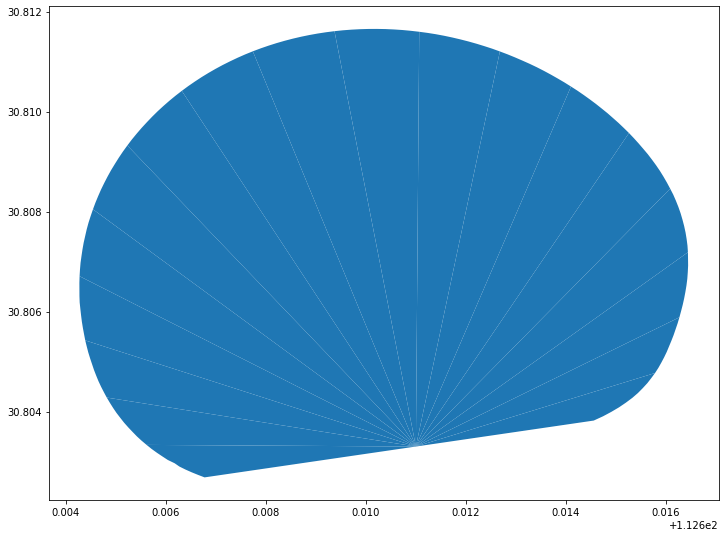

In [50]:
gdfdata.loc[1:1,].plot(figsize =[12,12])

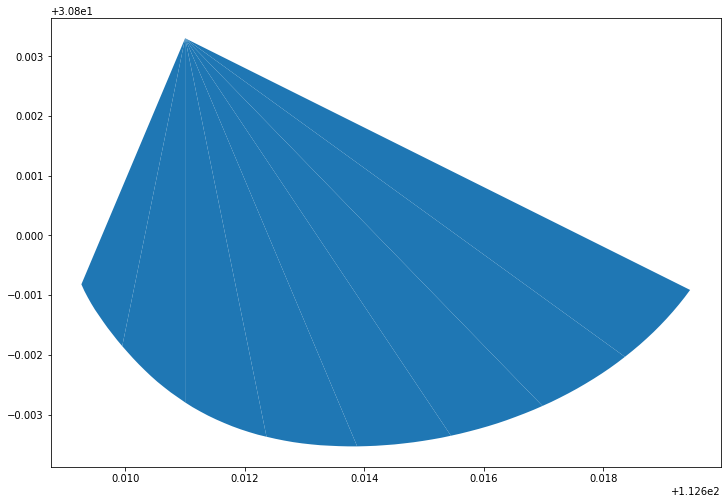

In [51]:
data_fg.head(8).plot(figsize =[12,12])

# 进行覆盖模型修正-按照hata覆盖模型和站高进行修正

In [55]:
jd_dp['电平']

0     -0.034002
1     -0.060002
2     -0.094139
3     -0.134920
4     -0.181400
         ...   
355   -0.014686
356   -0.003541
357    0.000000
358   -0.003818
359   -0.015188
Name: 电平, Length: 360, dtype: float64

In [64]:
jd_dp['距离_模型'] = np.power(10,(148-jd_dp['电平'] - (46.3+33.9*np.log10(1800)-13.82*np.log10(30)-(-3.81))- 3)/(44.9-6.55*30))*1000

In [71]:
jd_dp.to_clipboard()

In [70]:
jd_dp['距离'] = jd_dp['电平_正'].apply(lambda x: x/37.052 *927)